Epoch 1/30, Loss: 0.6520, Accuracy: 76.41%, Time: 3.09s
Epoch 2/30, Loss: 0.3120, Accuracy: 88.94%, Time: 3.03s
Epoch 3/30, Loss: 0.2712, Accuracy: 90.69%, Time: 3.03s
Epoch 4/30, Loss: 0.2083, Accuracy: 92.63%, Time: 3.04s
Epoch 5/30, Loss: 0.1853, Accuracy: 94.19%, Time: 3.01s
Epoch 6/30, Loss: 0.1590, Accuracy: 94.75%, Time: 3.19s
Epoch 7/30, Loss: 0.1287, Accuracy: 94.65%, Time: 3.13s
Epoch 8/30, Loss: 0.0684, Accuracy: 97.05%, Time: 3.13s
Epoch 9/30, Loss: 0.0652, Accuracy: 97.42%, Time: 3.02s
Epoch 10/30, Loss: 0.0242, Accuracy: 99.26%, Time: 3.04s
Epoch 11/30, Loss: 0.0246, Accuracy: 98.99%, Time: 3.06s
Epoch 12/30, Loss: 0.0226, Accuracy: 99.17%, Time: 3.07s
Epoch 13/30, Loss: 0.0308, Accuracy: 99.08%, Time: 3.05s
Epoch 14/30, Loss: 0.0197, Accuracy: 99.26%, Time: 3.05s
Epoch 15/30, Loss: 0.0157, Accuracy: 99.26%, Time: 3.09s
Epoch 16/30, Loss: 0.0163, Accuracy: 99.26%, Time: 3.06s
Epoch 17/30, Loss: 0.0108, Accuracy: 99.54%, Time: 3.09s
Epoch 18/30, Loss: 0.0103, Accuracy: 99.

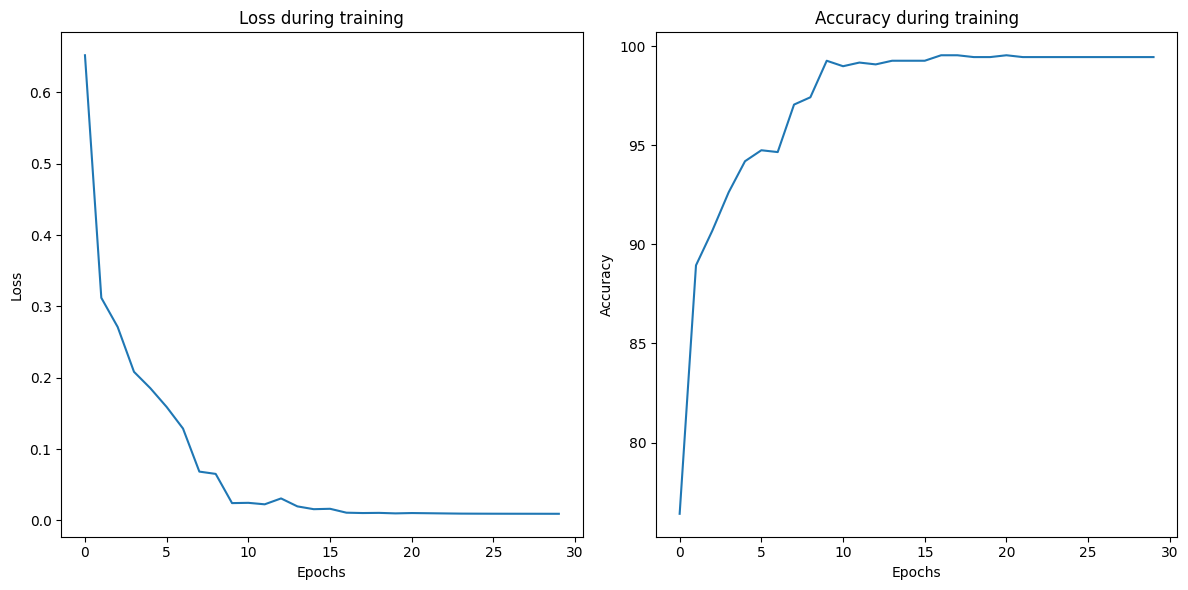

In [8]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import transforms
import matplotlib.pyplot as plt
import time

# 数据加载与预处理
class VehicleDataset(data.Dataset):
    def __init__(self, img_paths, labels, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx])
        if self.transform:
            img = self.transform(img)
        
        label = self.labels[idx]
        return img, label

# 预处理步骤，包括调整图片大小和归一化
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # 图片拉伸到统一大小
    transforms.ToTensor(),  # 转换为tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 归一化
])

# 加载数据
def load_data(data_dir, test_size=0.2):
    labels = {'bus': 0, 'car': 1, 'truck': 2}
    img_paths = []
    img_labels = []

    # 遍历每个类别
    for label_name, label in labels.items():
        class_path = os.path.join(data_dir, label_name)
        for img_name in os.listdir(class_path):
            # 忽略隐藏文件和非图像文件
            if img_name.startswith('.') or not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue
            img_path = os.path.join(class_path, img_name)
            img_paths.append(img_path)
            img_labels.append(label)

    # 划分训练集和测试集，随机抽取20-30%的数据作为测试集
    X_train, X_test, y_train, y_test = train_test_split(img_paths, img_labels, test_size=test_size, stratify=img_labels)
    
    train_dataset = VehicleDataset(X_train, y_train, transform)
    test_dataset = VehicleDataset(X_test, y_test, transform)
    
    return train_dataset, test_dataset

# 手动实现卷积层
class CustomConv2d(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(CustomConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        
        # 卷积核初始化，随机初始化权重
        self.weight = torch.nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size))
        self.bias = torch.nn.Parameter(torch.zeros(out_channels))

    def forward(self, x):
        # 使用手动卷积操作
        return F.conv2d(x, self.weight, self.bias, stride=self.stride, padding=self.padding)

# 手动实现最大池化层
class CustomMaxPool2d(torch.nn.Module):
    def __init__(self, kernel_size, stride=None, padding=0):
        super(CustomMaxPool2d, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

    def forward(self, x):
        # 使用手动池化操作
        return F.max_pool2d(x, self.kernel_size, self.stride, self.padding)

# 自定义卷积神经网络
class CustomConvNet(torch.nn.Module):
    def __init__(self):
        super(CustomConvNet, self).__init__()

        # 自定义卷积和池化层
        self.conv1 = CustomConv2d(3, 8, kernel_size=3, stride=1, padding=1)
        self.pool = CustomMaxPool2d(kernel_size=2, stride=2)

        # 假设输入图像大小为128x128，经过两次池化后，图像大小为32x32
        self.feature_map_size = 32

        # 自定义全连接层
        self.fc1 = torch.nn.Linear(8 * self.feature_map_size * self.feature_map_size, 128)
        self.fc2 = torch.nn.Linear(128, 3)  # 输出3个类别

    def forward(self, x):
        # 卷积层 + 激活函数 + 池化层
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool(x)
        x = self.pool(x)  # 再次池化
        
        x = x.view(x.size(0), -1)  # 展平

        # 全连接层
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  # 输出层
        return x


# 训练函数
def train_model(train_loader, test_loader, model, criterion, optimizer, epochs=5):
    loss_history = []
    accuracy_history = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        start_time = time.time()
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # 计算准确率
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

        avg_loss = running_loss / len(train_loader)
        accuracy = 100 * correct_predictions / total_samples
        loss_history.append(avg_loss)
        accuracy_history.append(accuracy)

        epoch_time = time.time() - start_time
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%, Time: {epoch_time:.2f}s')
    
    return loss_history, accuracy_history

# 设置数据集路径
data_dir = r"C:\Users\37623\jupyter_test\Lab4\datasets\Vehicle_classification_dataset"

# 加载数据
train_dataset, test_dataset = load_data(data_dir)

# 使用DataLoader加载训练集和测试集
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# 初始化模型、损失函数和优化器
model = CustomConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# 训练模型
loss_history, accuracy_history = train_model(train_loader, test_loader, model, criterion, optimizer, epochs=30)

# 绘制训练结果图
def plot_training_history(loss_history, accuracy_history):
    plt.figure(figsize=(12, 6))

    # 绘制损失曲线
    plt.subplot(1, 2, 1)
    plt.plot(loss_history, label='Loss')
    plt.title('Loss during training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    # 绘制准确率曲线
    plt.subplot(1, 2, 2)
    plt.plot(accuracy_history, label='Accuracy')
    plt.title('Accuracy during training')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.tight_layout()
    plt.show()

# 绘制训练损失和准确率曲线
plot_training_history(loss_history, accuracy_history)